In [1]:
%cd ..
import jax.numpy as jnp
import matplotlib.pyplot as plt
from stencilnet.finite_volume import generate_rectilinear_mesh, u0, advection_solver

%cd examples/

/u/jp7427/Desktop/StencilNet
/u/jp7427/Desktop/StencilNet/examples


/u/jp7427/miniconda3/envs/ml/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# domain
n = 64
x, y = generate_rectilinear_mesh((0, 1), (0, 1), n)
u_init = u0(x, y, type="square")

I0000 00:00:1706306600.339148   42038 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
# execute solver
U = advection_solver(
    u_init=u_init, h=(1 / n, 1 / n), v=(2, 1), T=1, cfl=0.8, p=3, forward="rk4"
)

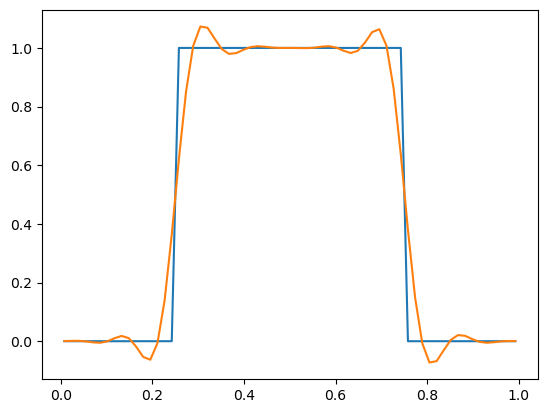

In [4]:
# plot
plt.plot(x[0], U[0, int(n / 2), :])
plt.plot(x[0], U[-1, int(n / 2), :])
plt.show()